# TP GAN
## Prérequis

Avoir suivi la formation GAN et avoir quelques bases avec PyTorch. Vous pouvez vous mettre sous les yeux le TP CNN.

## Introduction

L'objectif de ce TP est de coder un GAN pour générer des petits chats trop mignons. Il abordera les notions principales vues pendant la formation GAN : les CNN, convolutions transposées, batchnorm, binary crossentropy, comment entraîner tout ce beau monde... (et peut-être les problèmes de GAN si ça arrive mais pas de panique).

La plupart des détails sont déjà implémentés, vous allez surtout être amené à travailler sur l'architecture du générateur et du discriminateur ainsi que de comprendre comment les entraîner.


## Les imports


On va d'abord importer les librairies nécessaires dont les classiques numpy, matplotlib ainsi que Pytorch (quand même....) et certains de ses modules et classes utilisés utilisés souvent (Dataset, nn)

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch import nn

import matplotlib.pyplot as plt
from IPython.display import clear_output
import gdown
import os
from tqdm import tqdm
import pandas as pd

## Téléchargement du dataset


Importons maintenant le dataset. On va télécharget le dataset de chats depuis ce [drive](https://drive.google.com/uc?id=1F9I7iDmQ_I9Qsrav1UXlD4OiIBVSU5sl) avec la commande gdown (ou à la mano si vous préférez).


In [2]:
# Téléchargement du dataset
url = 'https://drive.google.com/uc?id=1F9I7iDmQ_I9Qsrav1UXlD4OiIBVSU5sl'
output = 'dataset.tgz'
if not os.path.exists(output):
    gdown.download(url, output, quiet=False)

# Dézippage du dataset

def unzip(zip_file, dest_dir):
    import zipfile
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(dest_dir)

unzip('dataset.tgz', './')

Downloading...
From (original): https://drive.google.com/uc?id=1F9I7iDmQ_I9Qsrav1UXlD4OiIBVSU5sl
From (redirected): https://drive.google.com/uc?id=1F9I7iDmQ_I9Qsrav1UXlD4OiIBVSU5sl&confirm=t&uuid=3fbb5423-b70b-4842-81ed-b36a496b1f9f
To: /content/dataset.tgz
100%|██████████| 49.7M/49.7M [00:00<00:00, 191MB/s]


## Quelques paramètres généraux

Les paramètres peuvent être modifiés pour tester un peu (sauf peut-être la taille de l'image pour ce dataset).

Pour ce dataset, on peut prendre une batch size pas trop grande sinon Colab crash (ou votre PC). De même, la dimension de l'espace latent peut être ajustée, ici vu que les chats c'est pas si simple, environ 100 c'est bien.

Pour charger le dataset, on parcourt notre dossier dataset en chargeant les images qui s'y trouvent. Les images ont leurs pixels entre 0 et 255 qu'on va renormaliser dès la création du dataset entre -1 et 1, ce qui est plus adapté pour les réseaux de neurones et bien pour des GAN car on a une moyenne nulle.

On va aussi les afficher parce que c'est bien de savoir sur quoi on travaille quand même (et puis pourquoi se priver de photos de chats...).

In [3]:
BATCH_SIZE = 64
LATENT_DIM = 100
IMG_SHAPE = (64,64,3)

x_train = []
batch = []
i = 0

for files in os.listdir("./dataset"):
  image = read_image(f"./dataset/{files}")

  # On normalise les données entre -1 et 1

  image = (image - 127.5)/127.5

  if i < BATCH_SIZE:
    batch.append(image)
    i += 1
  else:
    x_train.append(torch.stack(batch))
    batch = []
    i = 0


x_train = torch.stack(x_train)

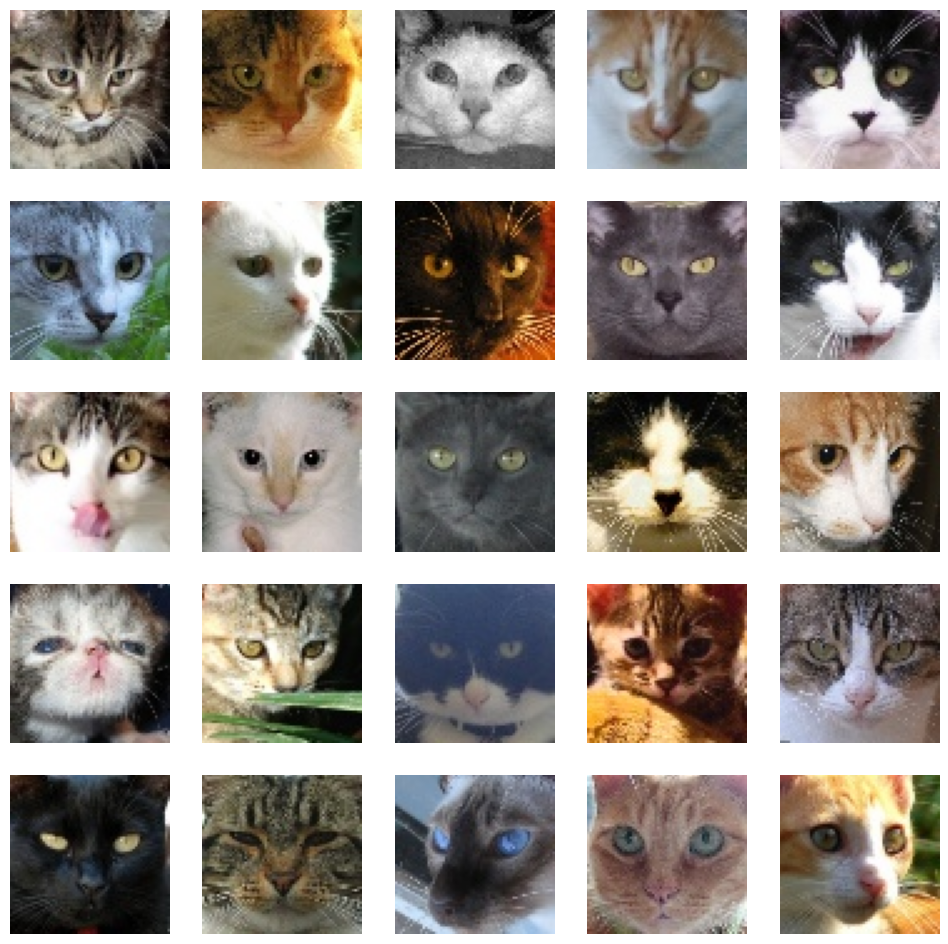

In [4]:
test_batch = next(iter(x_train))
test_batch = test_batch.permute(0,2,3,1)
fig = plt.figure(figsize=(12,12))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.axis('off')
  # On oublie pas de faire image * 0.5 + 0.5 pour revenir dans [0,1]
  plt.imshow(test_batch[i]*0.5+0.5)
plt.show()

## Pytorch et les GPUs...





Pytorch a besoin qu'on lui précise avec quel appareil on travaille (CPU ou GPU par exemple).

Du coup, ici on choisit le meilleur appareil disponible (généralement GPU, sinon CPU).

In [5]:
device = (
    ("cuda")
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


## Le discriminateur


On va d'abord faire le discriminateur.

Pour cela on va définir le modèle en utilisant nn.Sequential(), comme dans les autres TP.

En entrée, on va avoir une image de dimension (3,64,64) (c'est en couleur pour rappel donc il y a bien 3 canaux).

Pour vous aider, un petit rappel des blocs à mettre:
- `Conv2D(in_features,out_features,kernel_size,strides,padding)`

  Typiquement, on utilise une taille de kernel de 3 et des filtres qui sont des puissances de 2 (32,64,128...).
  
  Pour rappel, le padding `'same'` équivaut à rajouter des zéros pour garder la même taille d'image en sortie (si les strides sont de 1) et avec `'valid'` on en rajoute pas. `'same'` est donc conseillé ici pour éviter les surprises (et de se torturer la tête sur la taille en sortie même si vous savez évidemment que c'est $\frac{n+2p-f}{s}+1$). A savoir que sur Pytorch **cela ne marche pas forcément**, et que vous allez peut être devoir la préciser à la main.
   
   On ne met pas l'activation tout de suite car on ajoute d'abord de la batch normalization pour renormaliser le batch en 0 et ainsi profiter au maximum de la non-linéarité de la ReLU en ce point.

  Pour rappel, on augmente le nombre de filtres au fur et à mesure de l'architecture dans le discriminateur.
- `BatchNorm2D(in_features)`
- `LeakyReLU(alpha=0.2)` (pente de la leaky relu dans le domaine $]-\infty,0]$)

Mettez 3-4 blocs comme ça et faites des essais.

Ici pas de `Pooling` car on réduit la taille des images directement avec du stride (typiquement 2 à chaque Convolution en comptant bien la taille qu'on obtient à la fin).

En sortie on veut une dimension (1) grâce à une `Flatten` puis des `Dense` en oubliant pas la sigmoïde à la fin.

*Alternative* :
- C'est aussi possible de bien calculer la taille de l'image pour terminer par une `Convolution` avec une sortie de dimension (1,1,1) puis une `Flatten` (un peu mieux, dit "Full Convolutional").

  **Exemple** :
  - Image de (64,64,3) -> 4 Blocs de convolution avec du stride de 2 : $64/2^4$ -> Feature map de taille (4,4,nombre_de_filtres).

    On peut ensuite finir avec une `Conv2D` avec une taille de filtre de 4 et du padding `'valid'` pour juste faire une combinaison de tous les pixels restants, ce qui nous donne bien notre unique pixel de dimension (1,1,1) sans oublier la sigmoïde et on peut ensuite `Flatten` tout ça).


Juste ici, petite antisèche de l'architecture si vous séchez. Attention l'écriture est en pseudo-code, il faut l'adapter à Pytorch.
<details>
<summary>Antisèche</summary>
Conv2D(3 filtres en entrée, 32 filtres,kernel taille 3,stride 2,padding 1) -> BN -> LR <br />  
-> Conv2D(64,kernel 3,stride 2,padding 1) -> BN -> LR <br />  
-> Conv2D(128,3,2,1) -> BN -> LR <br />  
-> Conv2D(256,3,2,1) -> BN -> LR <br />  
-> Conv2D(1,4,1,1) -> Sigmoïde -> Flatten ou Flatten -> Linear(1) -> Sigmoïde
</details>

In [6]:
discriminator = nn.Sequential(
            ##1er block
            nn.Conv2d(3,32,3,2,1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            ## 2eme block
            nn.Conv2d(32,64,3,2,1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            #3eme block
            nn.Conv2d(64,128,3,2,1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            #4eme block
            nn.Conv2d(128,256,3,2,1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256,1,4,1,padding='valid'),
            nn.Sigmoid(),
            nn.Flatten(),
            ).to(device)


## Le générateur

On va faire le générateur.
En entrée, il va prendre un vecteur de l'espace latent de dimension `latent_dim`.

On augmente la taille de se vecteur grâce à une couche dense.

`Linear(latent_dim, 4x4x1024)`

Pour redimensionner notre vecteur en une "image" de taille 4 x 4 x 1024, on va pouvoir utiliser la couche `Unflatten()`


On peut aussi directement redimensionner le vecteur de l'espace latent sans la couche `Linear`.


Pour vous aider, un petit rappel des blocs à mettre ensuite:
- `Conv2DTranspose(in_features,out_features,kernel_size,strides,padding,output_padding)`

  Pour rappel, on diminue le nombre de filtres au fur et à mesure de l'architecture dans le générateur (512,256,...)

- `BatchNorm2D(in_features)`
- `ReLU()`

Mettez 2-3 blocs comme ça et faites des essais aussi. **Faites bien attention** à la taille de vos images tout au long de l'architecture pour bien avoir la taille d'image finale voulue.

**Exemple**:

- On a transformé notre vecteur latent en image de dimension (1024,4,4). Pour avoir du (3,64,64), il faut donc 4 blocs de `Conv2DTranspose` (avec padding) pour avoir $4*2^4=64$. Libre à vous de changer l'entrée pour mettre le nombre de blocs que vous voulez.


Ici aussi pas de `UpSampling2D` car on augmente la taille avec du stride (2 aussi souvent) à chaque convolution transposée.

En sortie on veut une dimension (64,64,3) grâce à une `Conv2D` avec 3 filtres, on oublie pas de prendre une activation en tangente hyperbolique `'tanh'` pour avoir des pixels dans [-1,1].

<details>
<summary>Antisèche</summary>
  (Dans le doute on peut flatten ici)
  Linear(100,4*4*1024 neurones) -> Unflatten(en (1024,4,4))
  -> ConvTransposée(1024, 256 filtres,kernel taille 3,stride 2,padding 1) -> BN -> ReLU <br />  
  -> ConvTransposée(256, 128,kernel 3,stride 2,padding 1) -> BN -> ReLU <br />  
  -> ConvTransposée(128, 64,3,2,1) -> BN -> ReLU <br />  
  -> ConvTransposée(64, 32,3,2,1) -> BN -> ReLU <br />  
  -> ConvTransposée(32, 3,3,1,1) -> Tanh

  /!\ je n'ai pas précisé l'`output_padding` dans l'antisèche, mais **il est peut être nécessaire d'en mettre** !
</details>

In [7]:
generator = nn.Sequential(nn.Linear(100, 4*4*1024),
                          nn.Unflatten(1, (1024, 4, 4)),
                          nn.ConvTranspose2d(1024,256,kernel_size=3,stride=2,padding=1,output_padding=1),
                          nn.BatchNorm2d(256),
                          nn.ReLU(),
                          nn.ConvTranspose2d(256,128,kernel_size=3,stride=2,padding=1,output_padding=1),
                          nn.BatchNorm2d(128),
                          nn.ReLU(),
                          nn.ConvTranspose2d(128,64,kernel_size=3,stride=2,padding=1,output_padding=1),
                          nn.BatchNorm2d(64),
                          nn.ReLU(),
                          nn.ConvTranspose2d(64,32,kernel_size=3,stride=2,padding=1,output_padding=1),
                          nn.BatchNorm2d(32),
                          nn.ReLU(),
                          nn.ConvTranspose2d(32,3,kernel_size=3,stride=1,padding=1,output_padding=0),
                          nn.Tanh(),
                          ).to(device)

## Le train step


Cette partie est assez importante car elle permet de comprendre comment on entraîne vraiment un GAN, c'est-à-dire à quoi on compare les sorties pour entraîner correctement le discriminateur et le générateur. Ici, pas de `model.fit` malheureusement.
On va définir un `train_step`, c'est à dire ce qu'on va faire comme opérations à chaque batch :

Entraîner le discriminateur :

- Générer des images fausses à partir de bruit gaussien et en prédire les labels : on a besoin ici d'un vecteur latent de dimension `(batch_size,latent_dim,1,1)`. Ensuite, on fait passer ce bruit dans le générateur pour obtenir des fausses images. Enfin, on récupère la sortie du discriminateur sur celles-ci.


```
noise = torch.randn(shape).to(device) (merci pytorch...)
fake_images = generator(...)
fake_predictions = discriminator(...)
```


- Prendre des images vraies du dataset et en prédire aussi les labels. Donc la sortie du discriminateur sur les vraies images.


```
real_predictions = ...
```


- Calculer la loss en comparant les prédictions sur les fausses avec des 0 et les prédictions sur les vraies avec des 1.



La binary crossentropy prend en argument les labels visés puis ceux prédits.
Pour avoir des 1 ou des 0 : `torch.ones_like(tensor)` ou `torch.zeros_like(tensor)` avec `tensor` le tenseur dont on veut imiter la taille (par exemple les labels issus des prédictions, vu que c'est à ça que l'on va vouloir les comparer). Dans l'exemple suivant, cela corresponds aux `true_labels` et les prédictions précédentes aux `predictions`.
```
discriminator_loss_on_real = loss(real_labels,real_predictions)
discriminator_loss_on_fake = loss(fake_labels,fake_predictions)
discriminator_loss = discriminator_loss_on_real + discriminator_loss_on_fake
```

On peut éventuellement diviser la loss du discriminateur par 2.

- Calculer les gradients en fonction de la loss calculée et les différents paramètres du modèle
- On applique les gradients calculés avec l'optimisateur choisi

Entraîner le générateur (presque la même chose):
- Générer des images fausses à partir de bruit gaussien et en prédire les labels.
- Calculer la loss en comparant les prédictions sur les fausses avec des 1 (on veut tromper le discriminateur).
- Calculer les gradients en fonction de la loss calculée et les différents paramètres du modèle
- On applique les gradients calculés avec l'optimisateur choisi

In [8]:
def train_step(real_images, generator, discriminator, loss, g_opt, d_opt):
  global LATENT_DIM
  batch_size = real_images.size(dim=0)


  noise = torch.randn(size = [batch_size,LATENT_DIM]).to(device)
  fake_images = generator(noise)

  ### On entraine le discriminateur

  d_opt.zero_grad()

  fake_images_predictions = discriminator(fake_images)
  real_images_predictions = discriminator(real_images)

  fake_labels = torch.zeros_like(fake_images_predictions)
  fake_labels = fake_labels.type_as(real_images)
  real_labels = torch.ones_like(real_images_predictions)
  real_labels = real_labels.type_as(real_images)

  ### On calcule la loss pour les vraies et les fausses images

  fake_loss = loss(fake_images_predictions,fake_labels)
  real_loss = loss(real_images_predictions,real_labels)

  disc_loss = (fake_loss + real_loss)/2

  ### Backpropagation

  disc_loss.backward()
  d_opt.step()
  #d_opt.zero_grad()



  ### On entraine le générateur

  generator.zero_grad()

  fake_images = generator(noise)
  fake_images_predictions = discriminator(fake_images)

  real_labels = torch.ones_like(real_images_predictions)
  real_labels = real_labels.type_as(real_images)

  ### On calcule la loss pour le générateur

  gen_loss = loss(fake_images_predictions,real_labels)

  ### Backpropagation

  gen_loss.backward()
  g_opt.step()
  #g_opt.zero_grad()
  return gen_loss,disc_loss

## Le train

On code la fonction d'entraînement principale.
Il reste à compléter la loss et les optimisateurs à utiliser, typiquement ici la `BCELoss()` et `Adam(parameters,lr=2e-4,betas = (0.5, 0.5)` (n'oubliez pas les parenthèses pour la loss !).

Dans un premier temps, on peut prendre les mêmes optimiseurs pour les deux quitte à adapter pour tester après (changer le learning rate par exemple pour rééquilibrer un peu l'entraînement).

In [9]:
def train(dataset,generator,discriminator,epochs,fixed_noise):

  ###A compléter###
  loss = nn.BCELoss()
  g_opt = torch.optim.Adam(generator.parameters(),lr=2e-4,betas=(0.5,0.5))
  d_opt = torch.optim.Adam(discriminator.parameters(),lr=2e-4,betas=(0.5,0.5))

  Lgen_loss = []
  Ldisc_loss = []
  X = []
  j = 0

  for epoch in range(epochs):
    progress_bar = tqdm(dataset)
    ##Vu que c'est un dataloader, on ne peut itérer directement dessus avec son indice. On va juste prendre à chaque fois batch par batch.
    for _,image_batch in enumerate(progress_bar):
        j += 1
        real_images = image_batch.to(device)
        gen_loss, disc_loss = train_step(real_images,generator,discriminator,loss,g_opt,d_opt)

        X.append(j)
        Lgen_loss.append(gen_loss.item())
        Ldisc_loss.append(disc_loss.item())

    clear_output(wait=False)
    generate_and_save_plots(X, Lgen_loss, Ldisc_loss) #Définie après, pour générer les courbes des loss
    summarize_performance(generator,fixed_noise) #Définie après, pour afficher les images générées

## L'affichage à chaque epoch


Petite fonction qui affiche les images obtenues à chaque epoch. On va **afficher** 25 images avec la même seed (toujours du même vecteur latent) pour voir l'amélioration progressive de l'image. Ce n'est pas de l'overfitting sur un seul vecteur car on **entraîne** bien à partir de vecteurs différents à chaque fois avant.

On affiche aussi après chaque epoch les courbes des loss du générateur et du discriminateur pour suivre l'entraînement et l'arrêter si on constate un souci.

In [10]:
def summarize_performance(generator,fixed_noise):
  fake_images = generator(fixed_noise).detach().cpu()
  fake_images = torch.permute(fake_images, (0, 2, 3, 1))
  fig = plt.figure(figsize=(12,12))
  for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(fake_images[i]*0.5+0.5)
  plt.show()

In [11]:
def generate_and_save_plots(X, Lgen_loss, Ldisc_loss):
    fig = plt.figure(figsize=(4,4))
    plt.plot(X,Lgen_loss, label = 'gen_loss')
    plt.plot(X,Ldisc_loss, label = 'disc_loss')
    plt.legend()
    plt.show()

## Ici vous lancez tout!

Choisissez le nombre d'epochs que vous voulez. Ici une vingtaine d'epochs peut suffire, on va pas attendre 3h quand même.

In [ ]:
EPOCHS = 15
fixed_noise = torch.randn(size=(25, LATENT_DIM)).to(device)
train(x_train,generator,discriminator,EPOCHS,fixed_noise)

  3%|▎         | 8/242 [00:36<15:37,  4.01s/it]

## Sauvegarde du modèle et inférence

Maintenant que votre modèle s'est entraîné pendant 10 minutes voir plus, ce serait con de le perdre et de devoir le réentraîner à chaque fois (en plus ça pollue c'est pas cool).
On va donc voir comment le sauvegarder sur votre drive et ensuite l'inférer, c'est-à-dire générer les images sans toucher aux poids.

In [ ]:
#Mount son drive
from google.colab import drive
drive.mount('/content/drive')

# Google va vous demander alors de vous logger avec votre compte google et accepter les conditions blabla...

On peut sauvegarder uniquement les poids du modèle à chaque fois pour ne pas avoir à stocker d'autres informations inutiles.

In [ ]:
#On save les poids du générateur dans un fichier .h5 avec la méthode .save_weights
torch.save(generator,'/content/drive/My Drive/generator.h5')

#Faire pareil pour le discriminateur
...

Ensuite il ne reste plus qu'à load les poids des deux modèles, générer des vecteurs latents et inférer le modèle dessus.
Pour inférer le modèle, on a déjà fait ça dans la boucle d'entraînement, il suffit de le considérer comme une simple fonction et faire ```model(entree)```

In [ ]:
#On peut alors charger les poids d'un modèle déjà entraîné avec .load_weights
generator = torch.load('/content/drive/My Drive/generator.h5')

#Faire pareil pour le discriminateur
...

#On peut alors générer des images avec le générateur
latent_vector = torch.randn(size=(25, LATENT_DIM, 1, 1)).to(device) #Création de 25 vecteurs latents aléatoires pour générer 25 images
fake_images = generator(latent_vector).detach().cpu()               #Génération des images avec le générateur
fake_images = torch.permute(fake_images, (0, 2, 3, 1))              #On déplace les dimensions de notre tenseur pour les adapter à un format compatible avec plt

fig = plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.axis('off')
    plt.imshow(fake_images[i]*0.5+0.5)
plt.show()

**Si vous êtes arrivé jusqu'ici dans le TP, c'est très bien !**

**Vous pouvez appeler un membre de l'association pour récupérer votre certification Automatants !**

# À développer

## Autres datasets

Vous pouvez essayer de générer des images sur d'autres datasets comme Fashion MNIST, CIFAR, CelebA ou n'importe quel type d'images qui vous font plaisir. S'il faut le télécharger et l'importer sur Colab, vous pouvez directement monter votre Drive et uploader votre dataset sur ce dernier.

## Autres architectures

Vous pouvez rajouter des blocs dans le générateur ou le discriminateur, essayer d'ajouter du Dropout, enlever les biais dans les couches, modifier la dimension de l'espace latent, initialiser les poids d'une certaine façon... Si vous êtes déjà à jour sur les CNN avancés (ResNET, MobileNet, EfficientNet), vous pouvez essayer de faire un GAN sur ces bases, ce qui permettra de résoudre certains problèmes comme les vanishing gradient.

## Tenter de forcer des problèmes

Faites n'importe quoi !

Plus sérieusement, cela peut arriver surtout sur des datasets plus compliqués, la plupart des choses fonctionnent pour MNIST à part si on fait exprès de provoquer des problèmes.

Vous pouvez essayer par exemple de déséquilibrer l'entraînement en modifiant les learning rate, en rajoutant beaucoup de couches seulement d'un côté...etc

Ici on peut forcer le mode collapse en prenant une dimension latente de seulement 1. Le générateur aura alors plus de risques de générer des images sur un seul mode.

## Tips d'entraînement possibles

- Utiliser une loss différente, du genre la Wasserstein loss.

- Changer le label visé pour les images vraies de 1 en 0.9

- Rajouter du bruit sur les images

- Ajouter des labels à l'entrée du générateur et du discriminateur (vous pourrez alors même choisir les classes des images générées)

- Entraîner le discrminateur plus que le générateur (typiquement entre 3 à 5 boucles d'entraînement à chaque fois que le générateur en fait une).


# Ce qu'il faut retenir de ce TP
- Architecture du générateur et du discriminateur :

  `Conv2D(Transpose) -> BatchNorm -> ReLU ou LeakyReLU`

  + Spécifités en entrée et sortie selon ce que l'on veut

  Eviter les fully connected/denses si possible

- Faire une boucle d'entraînement from scratch avec un train_step (très utile pour faire des choses plus compliquées)

  `Loss -> gradient_tape.gradient() -> optimizer.apply_gradients`